In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from CubicSplineInterpolator import CubicSplineInterpolator
%matplotlib inline
warnings.simple 

In [0]:
def f(t, x, z, b):
    return b * (z([t])[0] - x)

In [0]:
points_S = pd.read_csv("S.csv")
points_p = pd.read_csv("p.csv")
points_z = pd.read_csv("z.csv")
S = CubicSplineInterpolator(np.array(points_S["x"]), np.array(points_S["y"])).Compute
p = CubicSplineInterpolator(np.array(points_p["x"]), np.array(points_p["y"])).Compute
z = CubicSplineInterpolator(np.array(points_z["x"]), np.array(points_z["y"])).Compute

In [0]:
X_0 = 0
Y_0 = 0
A = 1
B = 10
T = 1
beta = 0.01
M = 1000
beta0 = 0
beta1 = 1

In [0]:
def phi(X_0, Y_0, A, B, T, beta, M):
    x = X_0
    y = Y_0
    xs = []
    ys = []
    p_xs = np.linspace(0, 1, M)
    p_CSI = CubicSplineInterpolator(p_xs, np.array(p(p_xs)))
    t_xs = np.linspace(0, T, M)
    z_CSI = CubicSplineInterpolator(t_xs, np.array(z(t_xs)))
    for t in t_xs:
        xs += [x]
        ys += [y]
        x_d = z_CSI.Grad([t])[0] * p_CSI.Integrate(y)
        y_d = f(t, x, z_CSI.Compute, beta) 
        x, y = x + x_d * T / M, y + y_d * T / M
    x_CSI = CubicSplineInterpolator(t_xs, np.array(xs))
    grad_xs = x_CSI.Grad(t_xs)
    p_ys = p_xs * np.array(p(p_xs))
    pp_CSI = CubicSplineInterpolator(p_xs, p_ys)
    for i in range(len(grad_xs)):
        grad_xs[i] *= pp_CSI.Integrate(ys[i])
    integral_CSI = CubicSplineInterpolator(t_xs, np.array(grad_xs))
    C1 = 1 - integral_CSI.Integrate(0, T) / (x - X_0)
    T_np = np.array([T])
    C2 = abs(x - np.array(S(T_np)[0])) / np.array(S(T_np)[0])
    return A * C1 + B * C2

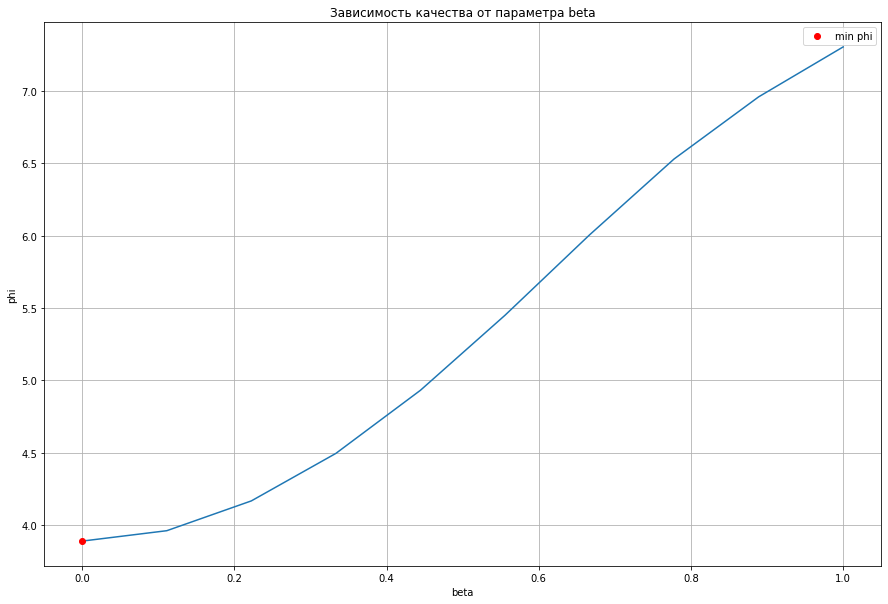

In [84]:
betas = np.linspace(beta0, beta1, 10)
phis = []
for b in betas:
    phis += [phi(X_0, Y_0, A, B, T, b, M)]
best_beta = betas[np.argmin(phis)]
plt.figure(figsize=(15, 10))
plt.plot(betas, phis)
plt.grid()
plt.plot(betas[np.argmin(phis)], np.min(phis), 'ro', label="min phi")
plt.legend()
plt.title("Зависимость качества от параметра beta")
plt.xlabel("beta")
plt.ylabel("phi")
plt.show()

In [0]:
def X_S(X_0, Y_0, T, beta, M):
    x = X_0
    y = Y_0
    xs = []
    ys = []
    p_xs = np.linspace(0, 1, M)
    p_CSI = CubicSplineInterpolator(p_xs, np.array(p(p_xs)))
    t_xs = np.linspace(0, T, M)
    z_CSI = CubicSplineInterpolator(t_xs, np.array(z(t_xs)))
    for t in t_xs:
        xs += [x]
        ys += [y]
        x_d = z_CSI.Grad([t])[0] * p_CSI.Integrate(y)
        y_d = f(t, x, z_CSI.Compute, beta) 
        x, y = x + x_d * T / M, y + y_d * T / M
    return xs

In [99]:
print(best_beta)

0.0


In [0]:
NX = np.linspace(0, 1, 5)
NY = np.linspace(0, 1, 5)
HM = [[0] * 5 for i in range(5)]
T_np = np.array([T])
for i in range(5):
    for j in range(5):
        HM[i][j] = abs(X_S(NX[i], NY[j], T, best_beta, M)[-1] - S(T_np)[0])

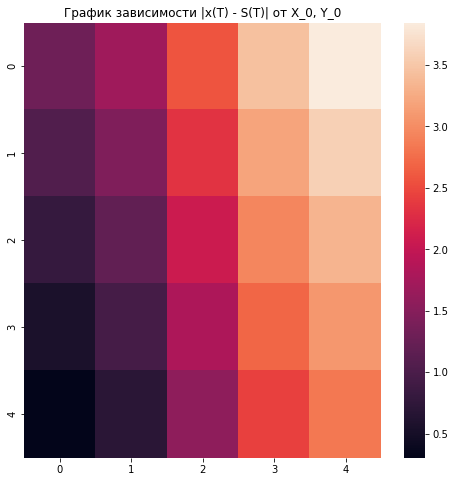

In [109]:
plt.figure(figsize=(8,8))
sns.heatmap(HM)
plt.title("График зависимости |x(T) - S(T)| от X_0, Y_0")
plt.show()

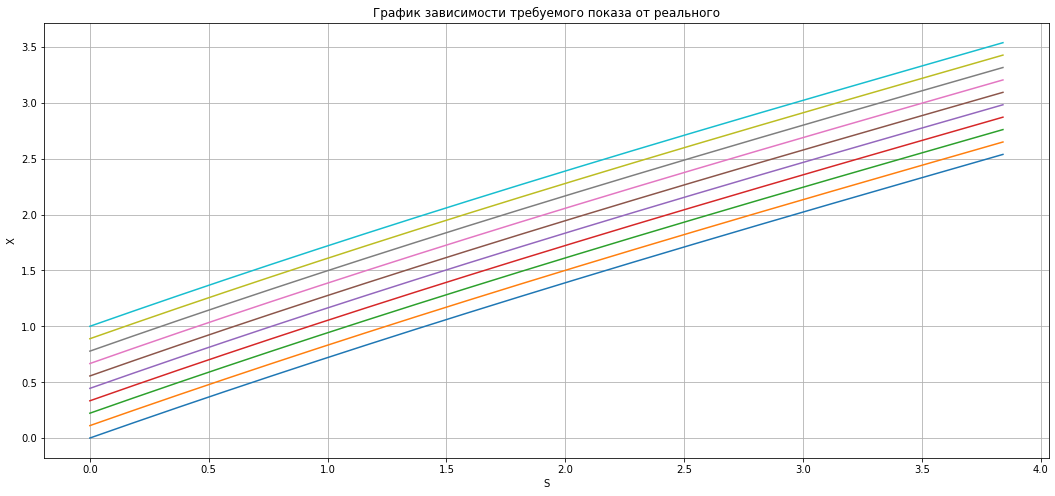

In [111]:
NX = np.linspace(0, 1, 10)
plt.figure(figsize=(18,8))
t_xs = np.linspace(0, T, M)
for i in range(10):
    xs = X_S(NX[i], Y_0, T, best_beta, M)
    plt.plot(S(t_xs), xs)
plt.title("График зависимости требуемого показа от реального")
plt.xlabel("S")
plt.ylabel("X")
plt.grid()
plt.show()